# MPSC Inference and Results lookup
<hr >

> In this notebook we will check our model performance in more details

## Table Of Content
<hr >

> 1. [Imports and Load](#Imports-and-Load)
>     - [Load data](#Load-data)
>     - [Load Model and Predict](#Load-Model-and-Predict)
> 2. [Error-analysis](#Error-analysis)
>     - [a quick look on the top worst predictions](#a-quick-look-on-the-top-worst-predictions)
>     - [which category has worst mae](#which-category-has-worst-mae)
>     - [name wordcloud based on error](#name-wordcloud-based-on-error)
>     - [item_description wordcloud based on error](#item_description-wordcloud-based-on-error)

## Imports and Load
<hr >

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for creating interactive visualizations
import seaborn as sns # data visualization library based on matplotlib
from wordcloud import WordCloud, STOPWORDS
import fasttext # used here for language detection
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers, Model
import joblib

2022-01-25 16:15:10.615410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-25 16:15:10.615437: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DATA_PATH = '../data/'
MODELS_PATH = '../models/'

TARGET = 'price'
SEED = 123
MAX_NUM_WORDS_NAME = 40000
MAX_NUM_WORDS_DESC = 80000
MAX_SEQ_LEN_NAME = 20
MAX_SEQ_LEN_DESC = 64

In [3]:
class Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    
class ColumnSelector(Transformer):
    def __init__(self, column=None, columns=None, fillna_value=None, fillna_from_column=None):
        self.column = column
        self.columns = columns
        self.fillna_value = fillna_value
        self.fillna_from_column = fillna_from_column
    
    def transform(self, df):
        if self.column and self.columns:
            raise Exception('You can not use both option [column, columns]')
        elif self.column:
            series = df[self.column]
        elif self.columns:
            series = df.apply(lambda x: ' '.join([str(x[f]) for f in self.columns]), axis=1)
        else:
            raise Exception('You have to chose one option [column, columns]')

        if self.fillna_from_column:
            series = series.fillna(df[self.fillna_from_column])
            
        if self.fillna_value:
            series = series.fillna(self.fillna_value)
        
        return series
    
    
class SubCategorySpliter(Transformer):
    def __init__(self, delimiter='/', maxsplit=2, nth_split=0):
        self.delimiter = delimiter
        self.nth_split = nth_split
        self.maxsplit = maxsplit
        
    def transform(self, series):
        return series.apply(lambda x: x.split(self.delimiter, self.maxsplit)[self.nth_split])
    
    
class SeriesToArray(Transformer):
    def __init__(self, shape=(-1, 1)):
        self.shape = shape
        
    def transform(self, series):
        return series.values.reshape(self.shape)
    
    
class TextToSeq(Transformer):
    def __init__(
        self,
        num_words=None,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        maxlen=100,
        sparse=True,
        dtype=np.uint32
    ):
        self.num_words = num_words
        self.filters = filters
        self.lower = lower
        self.maxlen = maxlen
        self.sparse = sparse
        self.dtype = dtype
        
    def fit(self, series, y=None):
        self.tokenizer = Tokenizer(num_words=self.num_words, filters=self.filters, lower=self.lower)
        self.tokenizer.fit_on_texts(series)
        
        return self
        
    def transform(self, series):
        seqs = self.tokenizer.texts_to_sequences(series)
        pad_seqs = pad_sequences(seqs, maxlen=self.maxlen, dtype=self.dtype)
        if self.sparse:
            pad_seqs = csr_matrix(pad_seqs)
        
        return pad_seqs
    
    
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, pipes, target, batch_size=1024, train=True, shuffle=True):
        self.df = df
        self.pipes = pipes
        self.target = target
        self.train = train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df)/ self.batch_size))
    
    def __getitem__(self, idx):
        sub_idxs = self.idxs[idx*self.batch_size:(idx+1)*self.batch_size]
        sub_df = self.df.iloc[sub_idxs]
        X, y = self.__data_generation(sub_df)
        
        return X, y

    def on_epoch_end(self):
        self.idxs = np.arange(len(self.df))
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, sub_df):
        X = [pipe.transform(sub_df) for pipe in self.pipes]
        if self.train:
            return X, np.log1p(sub_df[self.target].values)
        
        return X

### Load data

In [4]:
df_test = pd.read_csv(DATA_PATH+ 'mpsc_test.csv')
pipes = joblib.load(MODELS_PATH+ 'pipes.pkl')
dg_test = DataGenerator(df=df_test, pipes=pipes, target=TARGET, batch_size=2**12, shuffle=False)

/home/ab/env202201/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ab/env202201/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ab/env202201/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator FeatureUnion from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid res

### Load Model and Predict

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    
class CustomOutputLayer(layers.Layer):
    def __init__(self, min_val, max_val, **kwargs):
        super(CustomOutputLayer, self).__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val
        
    def call(self, inputs):
        outputs = tf.sigmoid(inputs)* (self.max_val- self.min_val)+ self.min_val
        output = tf.reduce_mean(outputs, axis=1, keepdims=True)
        
        return output
        
def get_model(seq_1_len, seq_2_len, feats_len, seq_1_max, seq_2_max, out_min_val, out_max_val, use_cuslayer=True):
    seq_1 = layers.Input((seq_1_len,))
    s_1 = layers.Embedding(seq_1_max, 128)(seq_1)
    s_1 = TransformerBlock(128, 4, 128)(s_1)
    s_1 = layers.GlobalAvgPool1D()(s_1)
    
    seq_2 = layers.Input((seq_2_len,))
    s_2 = layers.Embedding(seq_2_max, 128)(seq_2)
    s_2 = TransformerBlock(128, 4, 128)(s_2)
    s_2 = layers.GlobalAvgPool1D()(s_2)
    
    rest_ = layers.Input((feats_len,))
    
    vec = layers.Concatenate(axis=1)([s_1, s_2, layers.Dense(64)(rest_)])
    vec = layers.Dense(64)(vec)
    if use_cuslayer:
        out = CustomOutputLayer(out_min_val, out_max_val)(vec)
    else:
        out = layers.Dense(1)(vec)
        
    model = Model(inputs=[seq_1, seq_2, rest_], outputs=[out])
    
    return model

In [6]:
model_1 = get_model(pipes[0].transform(df_test.iloc[0:1]).shape[1],
                  pipes[1].transform(df_test.iloc[0:1]).shape[1],
                  pipes[2].transform(df_test.iloc[0:1]).shape[1],
                  MAX_NUM_WORDS_NAME,
                  MAX_NUM_WORDS_DESC,
                  0,
                  8
                 )
model_1.load_weights(MODELS_PATH+ 'model_1_weights.hdf')
df_test['pred_price'] = np.expm1(model_1.predict(dg_test, verbose=1))

2022-01-25 16:15:22.818179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 16:15:22.818892: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-25 16:15:22.819048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-25 16:15:22.819169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-25 16:15:22.819288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

73/73 [==============================] - 426s 5s/step


## Test Data EDA

In [ ]:
df_test['item_description'] = df_test['item_description'].fillna('No description yet')
df_test['category_name'] = df_test['category_name'].fillna('Other/Other/Other')
df_test['brand_name'] = df_test['brand_name'].fillna('Other')
df_test['main_cat'] = df_test['category_name'].apply(lambda x: x.split('/', maxsplit=2)[0])
df_test = df_test[[col for col in df_test.columns if not 'price' in col]+ ['price', 'pred_price']].drop('train_id', axis=1)

<hr >

Mean price is 26.747396518792982


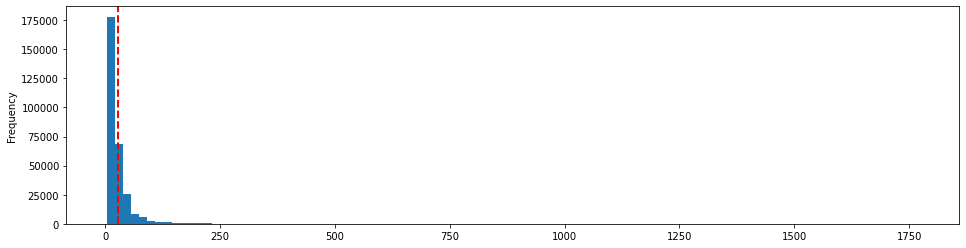

In [59]:
# First thing we can plot is the Target distribution
plt.figure(figsize=(16, 4))
df_test[TARGET].plot.hist(bins=100)
mean_price = df_test[TARGET].mean()
plt.axvline(mean_price, color='r', linestyle='dashed', linewidth=2)
print(f'Mean price is {mean_price}')

> We can see that price range and its mean are similar to train data

### A look at brands

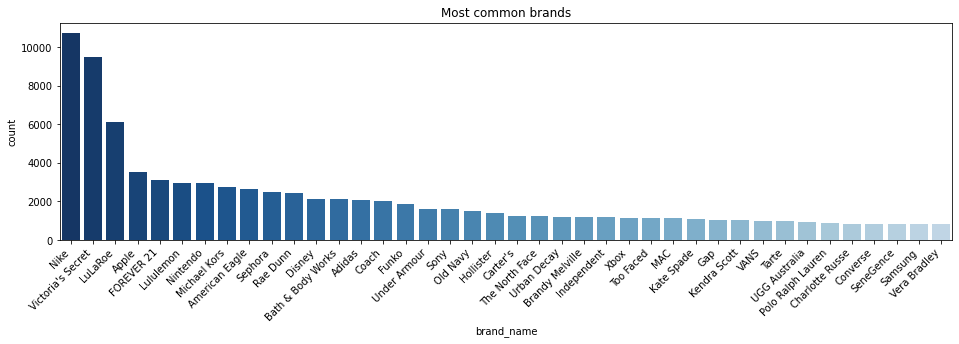

In [60]:
# plot the most common brands
df_ = df_test[df_test['brand_name'] != 'Other'].groupby('brand_name')[TARGET].count().reset_index()
df_.columns = ['brand_name', 'count']
df_ = df_.sort_values('count', ascending=False)
fig, ax = plt.subplots(figsize=(16, 4))
ax.set(title='Most common brands')
sns.barplot(data=df_.iloc[1:41], x='brand_name', y='count', palette=sns.color_palette('Blues_r', n_colors=40+15), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

### name analysis

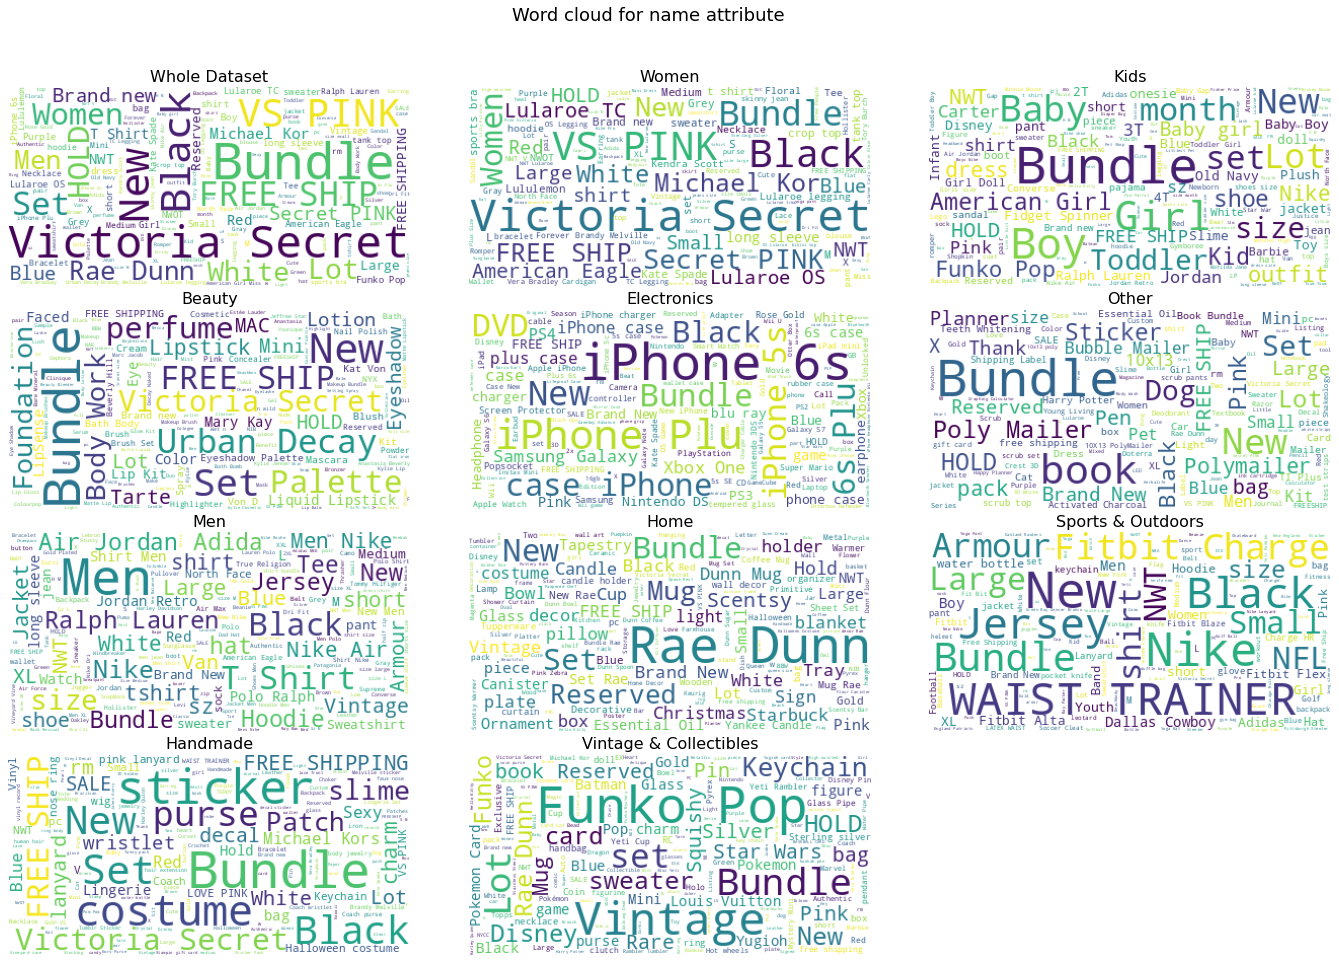

In [63]:
plt.figure(figsize=(24, 16))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.suptitle('Word cloud for name attribute', fontsize=18, y=0.95)
wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test['name']))
ax = plt.subplot(4, 3, 1)
ax.set_title(f'Whole Dataset', fontsize=16)
plt.imshow(wordcloud)
plt.axis('off')
    
for i, mc in enumerate(df_test['main_cat'].unique()):
    wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['main_cat'] == mc, 'name']))

    ax = plt.subplot(4, 3, i + 2)
    ax.set_title(f'{mc}', fontsize=16)
    plt.imshow(wordcloud)
    plt.axis('off')

Average number of words in name: 4.4 words


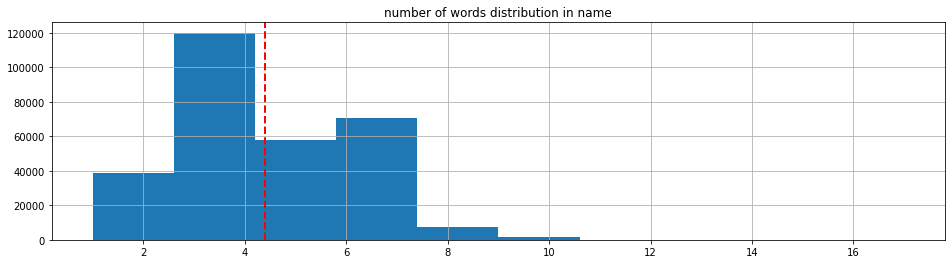

In [65]:
series_ = df_test['name'].apply(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(16, 4))
ax.set(title=f'number of words distribution in name')
series_.hist(bins=10)
plt.axvline(series_.mean(), color='r', linestyle='dashed', linewidth=2)
print(f'Average number of words in name: {series_.mean():.1f} words')

### description analysis

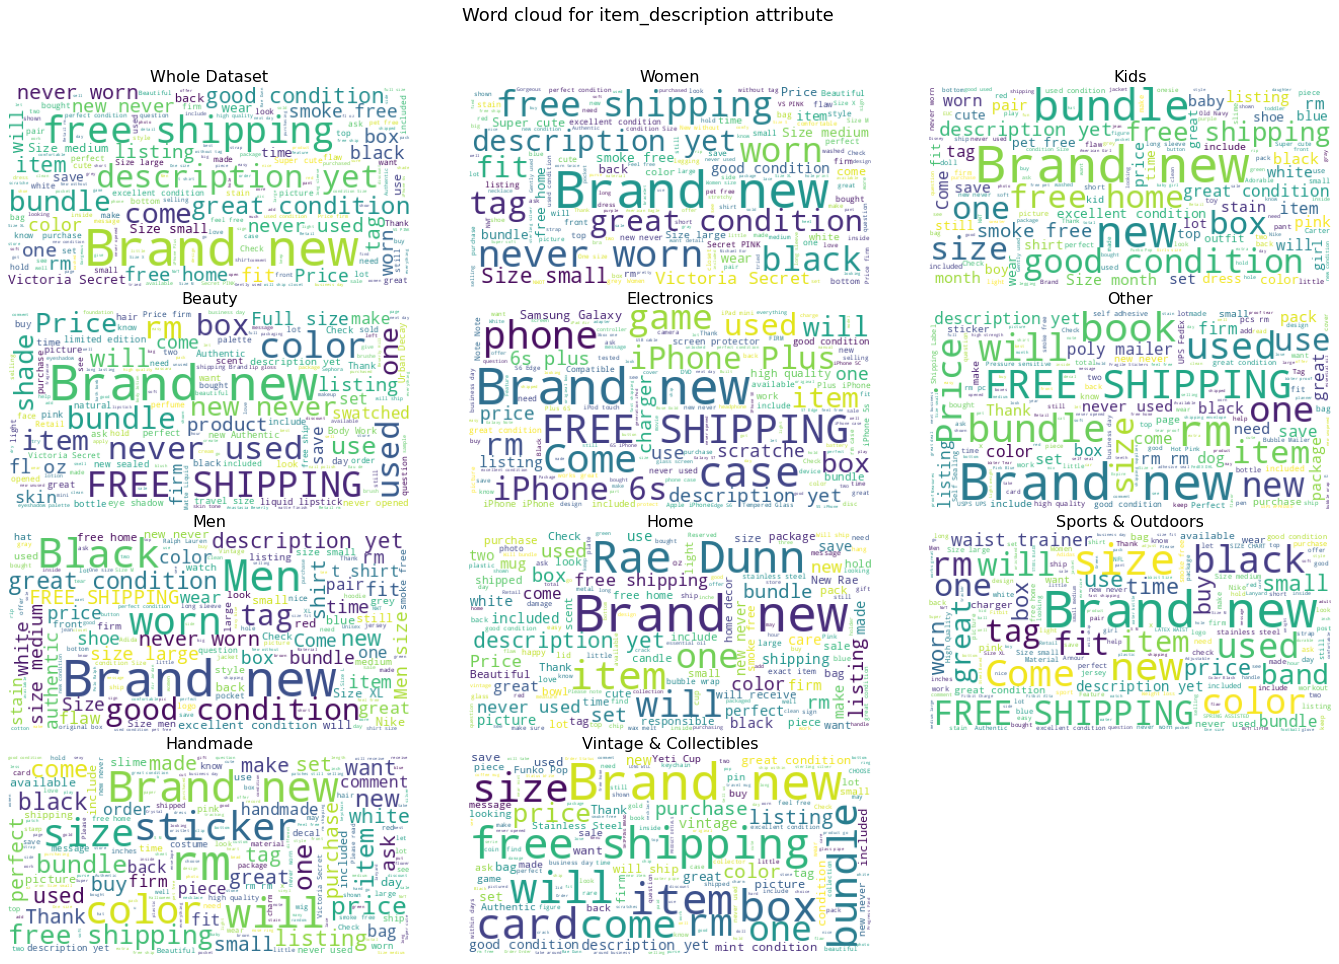

In [67]:
plt.figure(figsize=(24, 16))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.suptitle('Word cloud for item_description attribute', fontsize=18, y=0.95)
wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test['item_description']))
ax = plt.subplot(4, 3, 1)
ax.set_title(f'Whole Dataset', fontsize=16)
plt.imshow(wordcloud)
plt.axis('off')
    
for i, mc in enumerate(df_test['main_cat'].unique()):
    wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['main_cat'] == mc, 'item_description']))

    ax = plt.subplot(4, 3, i + 2)
    ax.set_title(f'{mc}', fontsize=16)
    plt.imshow(wordcloud)
    plt.axis('off')

Average number of words in item_description: 25.7 words


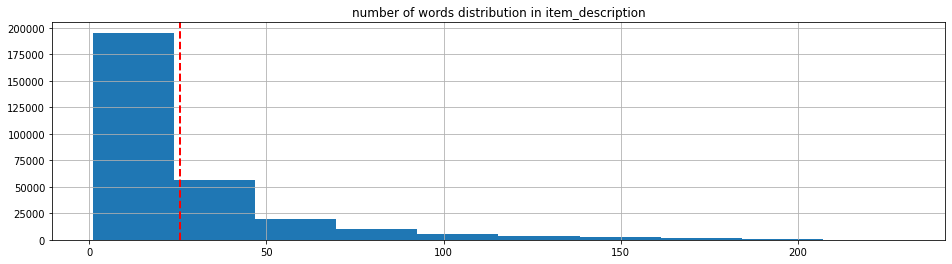

In [68]:
series_ = df_test['item_description'].apply(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(16, 4))
ax.set(title=f'number of words distribution in item_description')
series_.hist(bins=10)
plt.axvline(series_.mean(), color='r', linestyle='dashed', linewidth=2)
print(f'Average number of words in item_description: {series_.mean():.1f} words')

### How about the language in test set

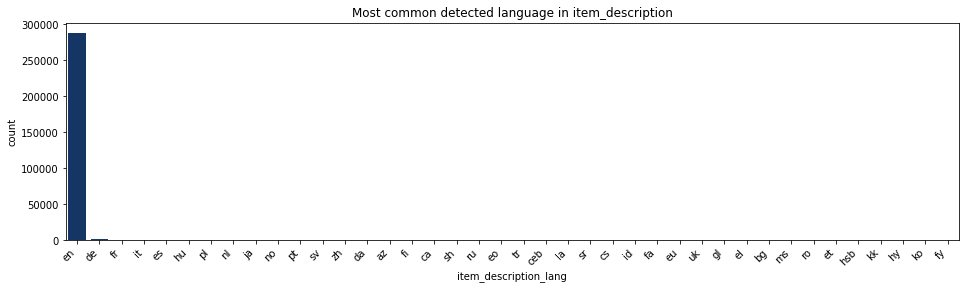

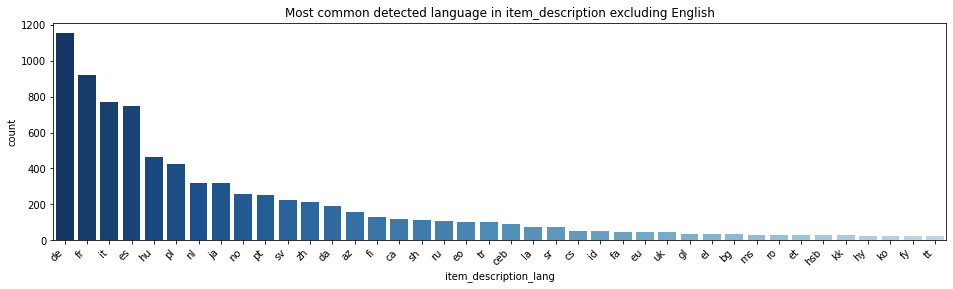

In [72]:
fmodel = fasttext.load_model(MODELS_PATH+ 'lid.176.ftz')
df_test['item_description_lang'] = df_test['item_description'].apply(lambda x: fmodel.predict(x, k=1)[0][0][len('__label__'):])
df_ = df_test.groupby('item_description_lang')['name'].count().reset_index()
df_.columns = ['item_description_lang', 'count']
df_ = df_.sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(16, 4))
ax.set(title='Most common detected language in item_description')
sns.barplot(data=df_.iloc[0:40], x='item_description_lang', y='count', palette=sns.color_palette('Blues_r', n_colors=40+15), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

fig, ax = plt.subplots(figsize=(16, 4))
ax.set(title='Most common detected language in item_description excluding English')
sns.barplot(data=df_.iloc[1:41], x='item_description_lang', y='count', palette=sns.color_palette('Blues_r', n_colors=40+15), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Error analysis
<hr >

In [8]:
msle = np.mean((np.log1p(df_test['pred_price']) - np.log1p(df_test['price']))** 2)
print(f'Test dataset msle: {msle}')

Test dataset msle: 0.19201983420331936


In [46]:
len_zeros = df_test[df_test['price'] == 0].shape[0]
print(f'We have {len_zeros} items have price of zero we will exclode them for our analysis purpose')
df_test = df_test[df_test['price'] == 0]

We have 173 items have price of zero we will exclode them for our analysis purpose


### quick look into test data and our predictions

> We will use absolute error and absolute percentge error for analysis

In [47]:
df_test['abs_err'] = np.abs(df_test['price']- df_test['pred_price'])
df_test['abs_perc_err'] = df_test['abs_err']/ df_test['price']
df_test

name  item_condition_id  \
0                       On hold for Chelseychu                  2   
1                             Lace up leggings                  2   
2            Zipper High Top All Star Converse                  3   
3                                       Sperry                  3   
4                                 Lipsense set                  1   
...                                        ...                ...   
296502                              Hatchimals                  1   
296503  Men's Medium Beige Columbia Sweatshirt                  3   
296504                        Tommy Hilfiger T                  3   
296505  Womens Stretchy Plus Size Dress Sz 2XL                  1   
296506                New medium carly lularoe                  1   

                                    category_name      brand_name  shipping  \
0             Women/Women's Handbags/Shoulder Bag     Hello Kitty         0   
1                        Women/Pants/Casual Pants           Other         1   
2                    Women/Shoes/Fashion Sneakers        Converse         0   
3                          Kids/Girls 2T-5T/Shoes           Other         0   
4                              Beauty/Makeup/Lips       SeneGence         1   
...                                           ...             ...       ...   
296502          Kids/Toys/Stuffed Animals & Plush           Other         0   
296503  Men/Sweats & Hoodies/Sweatshirt, Pullover        Columbia         0   
296504              Women/Tops & Blouses/T-Shirts  Tommy Hilfiger         0   
296505                  Women/Dresses/Knee-Length           Other         0   
296506             Women/Dresses/Asymmetrical Hem         LuLaRoe         1   

                                         item_description main_cat  price  \
0       Black faux leather hello kitty satchel comes w...    Women   31.0   
1                                   Only worn for picture    Women   15.0   
2       Size 7 women's Great for your feet! Check out ...    Women   26.0   
3       Pink Size 6 toddler Used Very good condition G...     Kids   16.0   
4          Bella color with Glossy gloss and oops remover   Beauty   50.0   
...                                                   ...      ...    ...   
296502  Hatchimals Hatchimals Penguala pink/yellow new...     Kids  161.0   
296503  Men's medium beige Columbia sweatshirt - soft ...      Men   14.0   
296504  Small yellow spot next to tag, not noticeable ...    Women   14.0   
296505  Womens Plus Size Dress Size 2XL New With Tags ...    Women   16.0   
296506                             New Med Purple leopard    Women   40.0   

        pred_price    abs_err  abs_perc_err  
0        30.192432   0.807568      0.026051  
1        10.958035   4.041965      0.269464  
2        25.047085   0.952915      0.036651  
3        14.022301   1.977699      0.123606  
4        49.763771   0.236229      0.004725  
...            ...        ...           ...  
296502  106.213158  54.786842      0.340291  
296503   15.118613   1.118613      0.079901  
296504   10.576239   3.423761      0.244554  
296505   12.607712   3.392288      0.212018  
296506   44.065086   4.065086      0.101627  

[296334 rows x 11 columns]

half of our predictions have absulte error less than 9.53


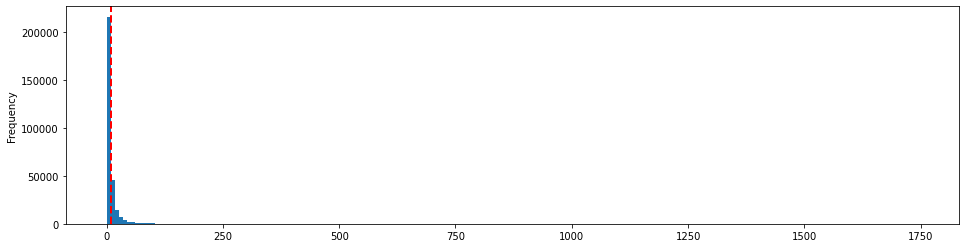

In [49]:
plt.figure(figsize=(16, 4))
df_test['abs_err'].plot.hist(bins=200)
plt.axvline(df_test['abs_err'].mean(), color='r', linestyle='dashed', linewidth=2)
mean_abs_err = df_test['abs_err'].mean()
print(f'half of our predictions have absulte error less than {mean_abs_err:.2f}')

half of our predictions have absulte percentage error less than 0.36


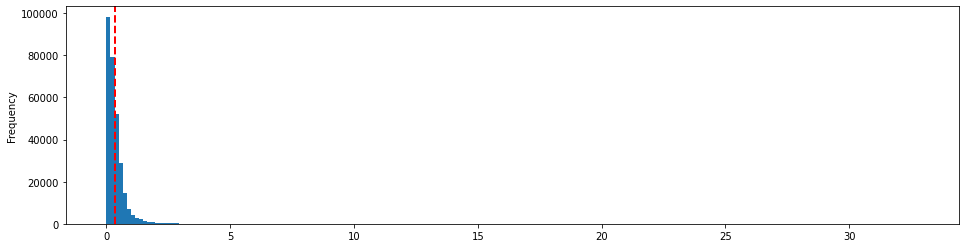

In [50]:
plt.figure(figsize=(16, 4))
df_test['abs_perc_err'].plot.hist(bins=200)
plt.axvline(df_test['abs_perc_err'].mean(), color='r', linestyle='dashed', linewidth=2)
mean_abs_perc_err = df_test['abs_perc_err'].mean()
print(f'half of our predictions have absulte percentage error less than {mean_abs_perc_err:.2f}')

### a quick look on the top worst predictions

In [36]:
df_test.sort_values('abs_perc_err').tail(25)

name  item_condition_id  \
251156               Oakley BATWOLF (Polarized)                  1   
282964   NWT VS PINK rainbow cowl neck pullover                  1   
295574          1 month of Xbox Gold Membership                  1   
117746  For Jennifer, wedding it u buy I cancel                  1   
195639               Lululemon Slate high times                  2   
172757                            Bape og yeezy                  1   
203176                 SAMSUNG GALAXY NOTE SPEN                  3   
180153                      Tieks Flower Yellow                  2   
211606            18k Gold with Diamond Accents                  1   
34429                           Tieks carry bag                  2   
75103                           Adidas NMD_R1 W                  1   
232064                  New Self Hoverboard Bag                  1   
22879                           3ds Face Plates                  2   
279456            Tory Burch Robinson Chain Bag                  3   
94336                OtterBoxcase iPad Air 9.7"                  3   
191419                Supreme sticker nmd yeezy                  1   
210322    Lego 28 pcs Brick masonry profile 1x2                  1   
207241           Diamond skateboarding hardware                  1   
45768        •WILDFOX• Two Hearts Malibu Hoodie                  1   
28263                            MamaRoo mobile                  3   
211252              Michael Kors protective bag                  2   
277274             Coach Signature Top Zip Tote                  1   
279364               Adidas uncaged ultra boost                  1   
41652                  Jim Dunlop Ultex (1.0mm)                  1   
232556               Jim Dunlop Tortex (1.14mm)                  1   

                                            category_name        brand_name  \
251156                   Men/Men's Accessories/Sunglasses            Oakley   
282964                           Women/Sweaters/Cowl Neck              PINK   
295574  Electronics/Video Games & Consoles/Video Gamin...              Xbox   
117746                                Women/Jewelry/Rings         Swarovski   
195639     Women/Athletic Apparel/Pants, Tights, Leggings         Lululemon   
172757                        Men/Sweats & Hoodies/Hoodie              Nike   
203176  Electronics/Cell Phones & Accessories/Cell Pho...           Samsung   
180153                    Kids/Girls 0-24 Mos/Accessories             Other   
211606                            Women/Jewelry/Necklaces             Other   
34429                                   Women/Shoes/Flats             Other   
75103                                Women/Shoes/Athletic  adidas Originals   
232064              Sports & Outdoors/Outdoors/Skateboard             Other   
22879         Electronics/Video Games & Consoles/Consoles          Nintendo   
279456       Women/Women's Handbags/Messenger & Crossbody        Tory Burch   
94336   Electronics/Computers & Tablets/iPad/Tablet/eB...             Apple   
191419                         Men/Men's Accessories/Hats              Nike   
210322                            Kids/Toys/Building Toys              LEGO   
207241              Sports & Outdoors/Outdoors/Skateboard             Other   
45768                               Women/Sweaters/Hooded   Wildfox Couture   
28263                Kids/Gear/Swings, Jumpers & Bouncers           mamaRoo   
211252            Women/Women's Handbags/Totes & Shoppers      Michael Kors   
277274            Women/Women's Handbags/Totes & Shoppers             Coach   
279364                                 Men/Shoes/Athletic            Adidas   
41652                   Other/Musical instruments/Guitars        Jim Dunlop   
232556                  Other/Musical instruments/Guitars        Jim Dunlop   

        shipping                                   item_description  \
251156         0  Brand New Authentic Sunglasses and Frames! All...   
282964         1  ⭐️⭐️All

### which category has worst predictions

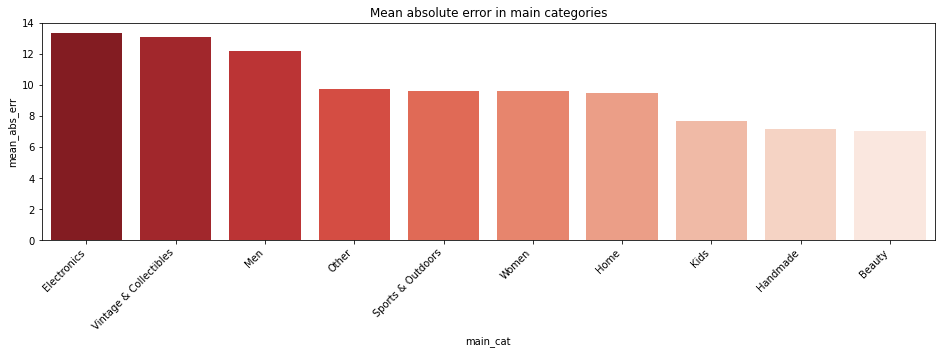

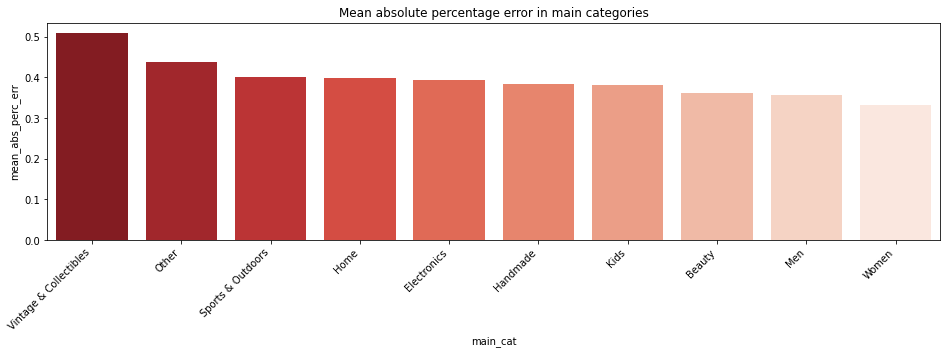

In [54]:
df_ = df_test.groupby('main_cat')['abs_err'].mean().sort_values(ascending=False).reset_index()
df_.columns = ['main_cat', 'mean_abs_err']
fig, ax = plt.subplots(figsize=(16, 4))
ax.set(title=f'Mean absolute error in main categories')
sns.barplot(data=df_, x='main_cat', y='mean_abs_err', palette=sns.color_palette('Reds_r', n_colors=10), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

df_ = df_test.groupby('main_cat')['abs_perc_err'].mean().sort_values(ascending=False).reset_index()
df_.columns = ['main_cat', 'mean_abs_perc_err']
fig, ax = plt.subplots(figsize=(16, 4))
ax.set(title=f'Mean absolute percentage error in main categories')
sns.barplot(data=df_, x='main_cat', y='mean_abs_perc_err', palette=sns.color_palette('Reds_r', n_colors=10), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

### name wordcloud based on error

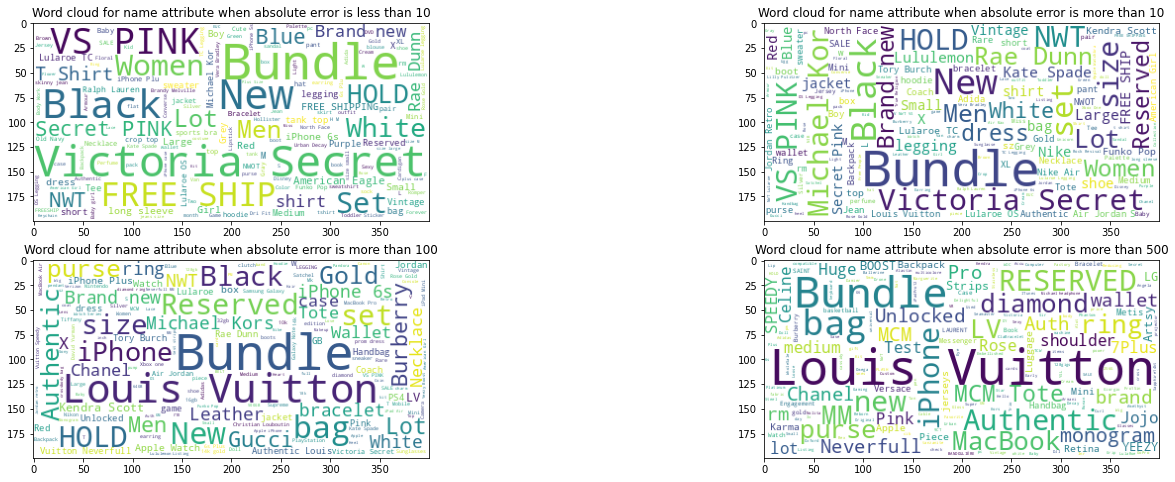

In [76]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
for i, r in enumerate([('l', 10), ('g', 10), ('g', 100), ('g', 500)]):
    if r[0] == 'l':
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_err']< r[1], 'name']))
        ax[i//2, i%2].set(title=f'Word cloud for name attribute when absolute error is less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_err']> r[1], 'name']))
        ax[i//2, i%2].set(title=f'Word cloud for name attribute when absolute error is more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)

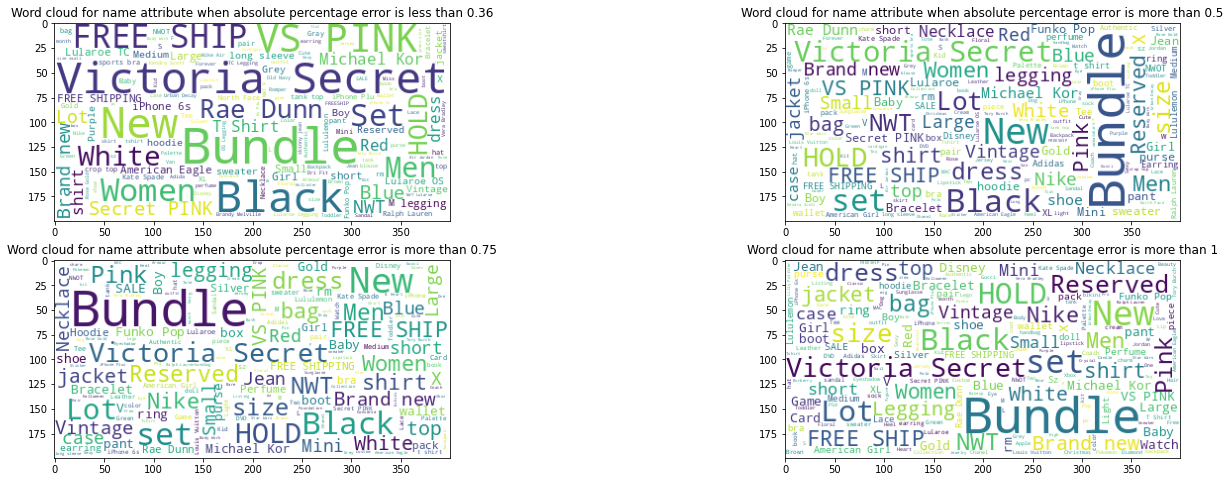

In [75]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
for i, r in enumerate([('l', .36), ('g', .5), ('g', .75), ('g', 1)]):
    if r[0] == 'l':
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_perc_err']< r[1], 'name']))
        ax[i//2, i%2].set(title=f'Word cloud for name attribute when absolute percentage error is less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_perc_err']> r[1], 'name']))
        ax[i//2, i%2].set(title=f'Word cloud for name attribute when absolute percentage error is more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)

### item_description wordcloud based on error

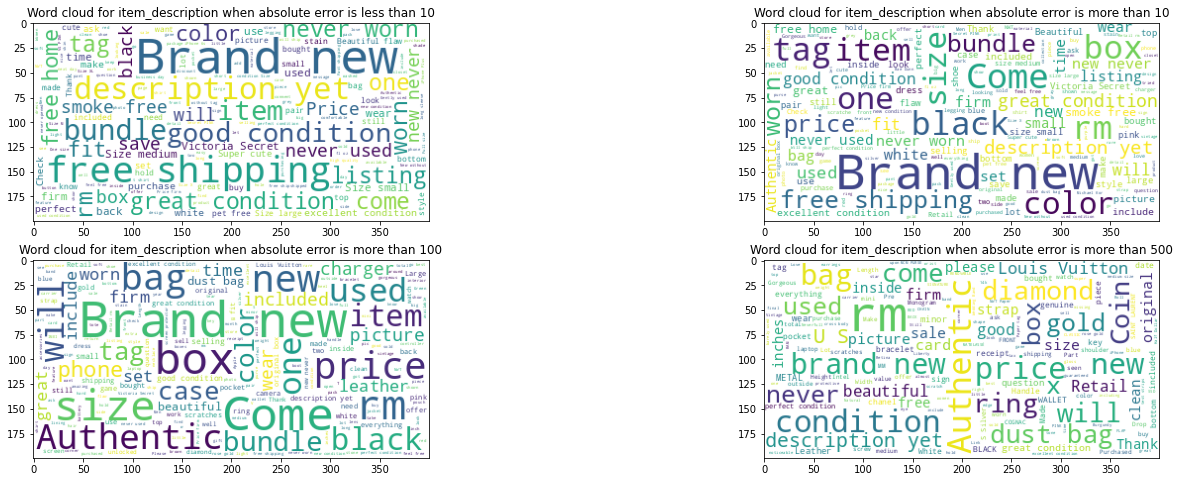

In [24]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
for i, r in enumerate([('l', 10), ('g', 10), ('g', 100), ('g', 500)]):
    if r[0] == 'l':
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_err']< r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'Word cloud for item_description when absolute error is less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_err']> r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'Word cloud for item_description when absolute error is more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)

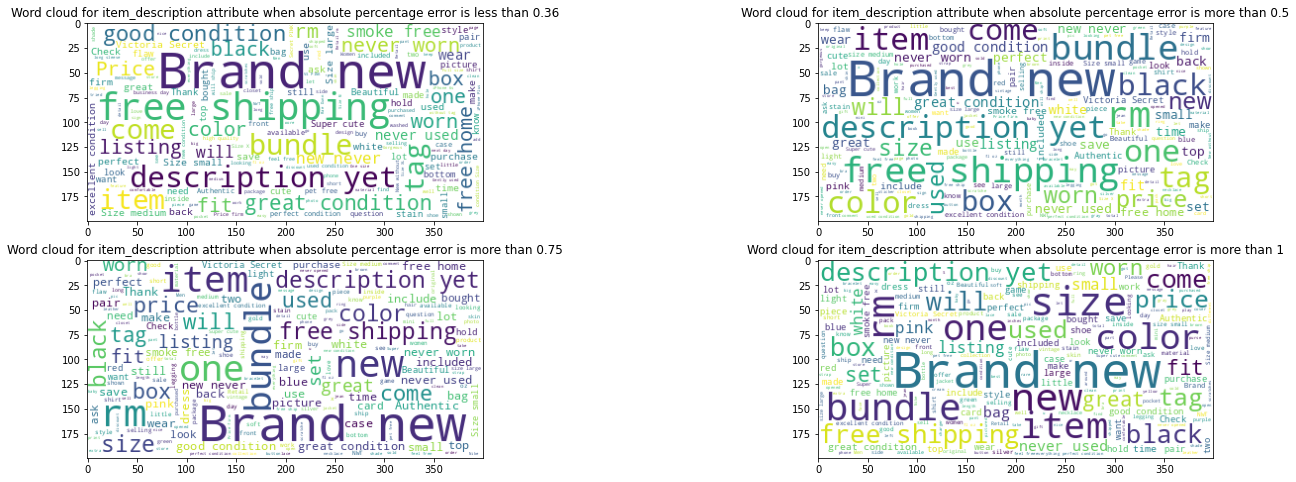

In [77]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
for i, r in enumerate([('l', .36), ('g', .5), ('g', .75), ('g', 1)]):
    if r[0] == 'l':
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_perc_err']< r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'Word cloud for item_description attribute when absolute percentage error is less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_perc_err']> r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'Word cloud for item_description attribute when absolute percentage error is more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)